# Assignment 1 - Image Deblurring
Name: Brian Schweigler<br>
Matriculation number: 16-102-071

In [319]:
import numpy as np
import scipy
import scipy.sparse
from scipy.sparse.linalg import inv
from PIL import Image
import matplotlib.pyplot as plt
from hessian_matrix import hessian_matrix

## Test Image
You can use the following function to create a synthetic image:

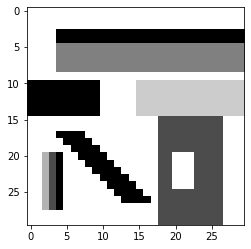

In [320]:
def create_random_binary_img_1():
    # RandInt returns an integer from 1 (inclusive) to 2 (exclusive), meaning it will always be 1 (and not random!)
    u = np.random.randint(1, 2, 30 * 30).reshape(30, 30).astype(float)
    u[5:9, 4:] = 0.5
    u[3:5, 4:] = 0
    u[10:15, :10] = 0
    u[10:15, 15:] = 0.8
    u[15:, 18:27] = 0.3

    for i in range(10):
        u[i + 17, i + 4:i + 8] = 0

    u[20:25:, 20:23] = 1
    u[20:28, 4] = 0
    u[20:28, 3] = 0.3
    u[20:28, 2] = 0.7

    return u


sample_image = create_random_binary_img_1()
plt.imshow(sample_image, cmap="gray")
plt.show()

## hessian_matrix() function
We provide the implementation of the hessian matrix for $k = 0, 1, 2, 3$.

input variables: 
- u: your image
- reg: regularization parameter
- k: one of the four kernel types 0-3 

Example usage:

In [321]:
u_ex = np.zeros(9).reshape(3, 3)
reg_ex = 1
k_type_ex = 3
A = hessian_matrix(u_ex, reg_ex, k_type_ex)
A_n_t = A.toarray()
print(A_n_t)

[[ 4.  -2.   0.  -2.   0.   0.   0.   0.   0. ]
 [-2.   6.5 -2.   0.5 -2.   0.   0.   0.   0. ]
 [ 0.  -2.   4.5  0.   0.5 -2.   0.   0.   0. ]
 [-2.   0.5  0.   6.5 -2.   0.  -2.   0.   0. ]
 [ 0.  -2.   0.5 -2.   9.  -2.   0.5 -2.   0. ]
 [ 0.   0.  -2.   0.  -2.   6.5  0.   0.5 -2. ]
 [ 0.   0.   0.  -2.   0.5  0.   4.5 -2.   0. ]
 [ 0.   0.   0.   0.  -2.   0.5 -2.   6.5 -2. ]
 [ 0.   0.   0.   0.   0.  -2.   0.  -2.   4. ]]


## Implementation

In [322]:
def derivative_img_term(g, u):
    """
    Derivative of the image term
    g: Blurred image
    u: The image
    """
    result = np.zeros(u.shape)
    for x in range(u.shape[0]):
        for y in range(u.shape[1]):
            # Corners
            if x == 0 and y == 0:
                result[x, y] = 0
            elif x == 0 and y == u.shape[1] - 1:
                result[x, y] = -g[0, y - 1] + 0.5 * u[1, y] + 0.5 * u[0, y]
            elif x == u.shape[0] - 1 and y == 0:
                result[x, y] = 0
            elif x == u.shape[0] - 1 and y == u.shape[1] - 1:
                result[x, y] = - g[x - 1, y - 1] + 0.5 * u[x, y] + 0.5 * u[x - 1, y]
            # Edges
            elif x == 0:  # Upper edge
                result[x, y] = - g[0, y - 1] + 0.5 * u[0, y] + 0.5 * u[1, y]
            elif x == u.shape[0] - 1:  # Lower edge
                result[x, y] = - g[x - 1, y - 1] + 0.5 * u[x, y] + 0.5 * u[x - 1, y]
            elif y == 0:  # Left edge
                result[x, y] = 0
            elif y == u.shape[1] - 1:  # Right edge
                result[x, y] = - g[x, y - 1] - g[x - 1, y - 1] + u[x, y] + 0.5 * u[x + 1, y] + 0.5 * u[x - 1, y]
            # Inside Image
            else:
                result[x, y] = u[x, y] + 0.5 * u[x + 1, y] + 0.5 * u[x - 1, y] - g[x, y - 1] - g[x - 1, y - 1]
    return result


def derivative_gp_reg_term(u):
    """
    Using Gaussian Prior Regularization Term
    u: The image
    """
    result = np.zeros(u.shape)
    for x in range(u.shape[0]):
        for y in range(u.shape[1]):
            # Corners
            if x == 0 and y == 0:
                result[x, y] = 4 * u[0, 0] - 2 * u[1, 0] - 2 * u[0, 1]
            elif x == 0 and y == u.shape[1] - 1:
                result[x, y] = 4 * u[0, y] - 2 * u[1, y] - 2 * u[0, y - 1]
            elif x == u.shape[0] - 1 and y == 0:
                result[x, y] = 4 * u[x, 0] - 2 * u[x - 1, 0] - 2 * u[x, 1]
            elif x == u.shape[0] - 1 and y == u.shape[1] - 1:
                result[x, y] = 4 * u[x, y] - 2 * u[x - 1, y] - 2 * u[x, y - 1]
            # Edges
            elif x == 0:  # Upper edge
                result[x, y] = 6 * u[0, y] - 2 * u[1, y] - 2 * u[0, y + 1] - 2 * u[0, y - 1]
            elif x == u.shape[0] - 1:  # Lower edge
                result[x, y] = 6 * u[x, y] - 2 * u[x - 1, y] - 2 * u[x, y + 1] - 2 * u[x, y - 1]
            elif y == 0:  # Left edge
                result[x, y] = 6 * u[x, 0] - 2 * u[x - 1, 0] - 2 * u[x + 1, 0] - 2 * u[x, 1]
            elif y == u.shape[1] - 1:  # Right edge
                result[x, y] = 6 * u[x, y] - 2 * u[x - 1, y] - 2 * u[x + 1, y] - 2 * u[x, y - 1]
            # Inside Image
            else:
                result[x, y] = 8 * u[x, y] - 2 * u[x - 1, y] - 2 * u[x + 1, y] - 2 * u[x, y + 1] - 2 * u[x, y - 1]
    return result


def derivative_atv_reg_term(u):
    """
    Using Anisotropic Total Variation Regularization Term
    u: The image
    """
    result = np.zeros(u.shape)
    for x in range(u.shape[0]):
        for y in range(u.shape[1]):
            # Corners
            if x == 0 and y == 0:
                result[x, y] = - np.sign(u[1, 0] - u[0, 0]) - np.sign(u[0, 1] - u[0, 0])
            elif x == 0 and y == u.shape[1] - 1:
                result[x, y] = np.sign(u[0, y] - u[0, y - 1]) - np.sign(u[1, y] - u[0, y])
            elif x == u.shape[0] - 1 and y == 0:
                result[x, y] = np.sign(u[x, 0] - u[x - 1, 0]) - np.sign(u[x, 1] - u[x, 0])
            elif x == u.shape[0] - 1 and y == u.shape[1] - 1:
                result[x, y] = np.sign(u[x, y] - u[x, y - 1]) + np.sign(u[x, y] - u[x - 1, y])
            # Edges
            elif x == 0:  # Upper edge
                result[x, y] = - np.sign(u[1, y] - u[0, y]) - np.sign(u[0, y + 1] - u[0, y]) - np.sign(
                    u[0, y] - u[0, y - 1])
            elif x == u.shape[0] - 1:  # Lower edge
                result[x, y] = np.sign(u[x, y] - u[x - 1, y]) + np.sign(u[x, y] - u[x, y - 1]) - np.sign(
                    u[x, y + 1] - u[x, y])
            elif y == 0:  # Left edge
                result[x, y] = - np.sign(u[x + 1, 0] - u[x, 0]) + np.sign(u[x, 0] - u[x - 1, 0]) - np.sign(
                    u[x, 1] - u[x, 0])
            elif y == u.shape[1] - 1:  # Right edge
                result[x, y] = np.sign(u[x, y] - u[x, y - 1]) + np.sign(u[x, y] - u[x - 1, y]) - np.sign(
                    u[x + 1, y] - u[x, y])
            # Inside Image
            else:
                result[x, y] = np.sign(u[x, y] - u[x - 1, y]) - np.sign(u[x + 1, y] - u[x, y]) - np.sign(
                    u[x, y + 1] - u[x, y]) - np.sign(u[x, y] - u[x, y - 1])
    return result


def GD(g, reg_lambda, action=""):
    """
    Gradient Descent algorithm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    Optional 'action': Variant to be used.
    """
    # TODO Test
    u = np.zeros((g.shape[0] + 1, g.shape[1] + 1))
    epsilon = 0.1

    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            u[x, y] = g[x, y]

    if action == "gauss":  # Gaussian Regularization
        gradient = derivative_img_term(g, u) + reg_lambda * derivative_gp_reg_term(u)
        # while (np.sum(np.power(gradient, 2)) > margin):
        for i in range(1000):
            u = u - epsilon * gradient
            gradient = derivative_img_term(g, u) + reg_lambda * derivative_gp_reg_term(u)
    elif action == "aniso":  # Anisotropic Total Variation
        gradient = derivative_img_term(g, u) + reg_lambda * derivative_atv_reg_term(u)
        for i in range(1000):
            u = u - epsilon * gradient
            gradient = derivative_img_term(g, u) + reg_lambda * derivative_atv_reg_term(u)
    else:  # No Regularization
        gradient = derivative_img_term(g, u)
        while np.sum(np.power(gradient, 2)) > 0.000001:
            u = u - epsilon * gradient
            gradient = derivative_img_term(g, u)
    return u

## Linearization and Gauss-Seidel

In [324]:
def LGS(g, reg_lambda):
    """
    Creating the initial image u (1 unit larger than g in both dimensions), which is set to g as a starting point.
    Until the difference between the two different u's is smaller than 0.00001, the Linearalized Gauss Seidel Algortihm is applied.

    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    """
    margin = 0.000001
    u = np.zeros((g.shape[0] + 1, g.shape[1] + 1))
    old_u = np.zeros((g.shape[0] + 1, g.shape[1] + 1))

    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            u[x, y] = g[x, y]

    while np.sum(np.power(old_u - u, 2)) > margin:
        old_u = u
        u = iterative_linearization(g, u, reg_lambda)

    return u

In [ ]:
def iterative_linearization(g, u, reg_lambda):
    """
    Gauss Seidel approach with linearized term using sparse matrices (speed-up!).
    g: Grayscale blurry image of size (m, n)
    u: Image passed from LSOR()
    reg_lambda: Regularization parameter
    """
    m, n = u.shape[0], u.shape[1]

    # Flatten image
    vector_u = u.reshape(m * n, 1)

    # Hessian Matrix
    hess_mat = hessian_matrix(u, reg_lambda, k)
    # Compute b
    b = hess_mat * vector_u - (derivative_img_term(g, u) + reg_lambda * derivative_gp_reg_term(u)).reshape(m * n, 1)
    # Triangular lower sparse matrix
    lower_mat = scipy.sparse.tril(hess_mat, k=0)
    # Triangular upper sparse matrix
    upper_mat = scipy.sparse.triu(hess_mat, k=1)

    vector_u = inv(lower_mat) * (b - upper_mat * vector_u)

    # Reshape flat image to initial size
    u = vector_u.reshape(m, n)

    return u

In [325]:
def iterative_linearization_SOR(g, u, reg_lambda, w):
    """
    Successive Over-Relaxation Approach, using sparse matrices (speed-up!) for the linearized term.
    g: Grayscale blurry image of size (m, n)
    u: Image passed from LSOR()
    reg_lambda: Regularization parameter
    w: SOR parameter
    """
    m, n = u.shape[0], u.shape[1]

    # Flatten image
    vector_u = u.reshape(m * n, 1)
    # Hessian Matrix
    hess_mat = hessian_matrix(u, reg_lambda, k)
    # Triangular lower sparse matrix
    lower_mat = scipy.sparse.tril(hess_mat, k=-1)
    # Triangular upper sparse matrix
    upper_mat = scipy.sparse.triu(hess_mat, k=1)
    # Diagonal sparse matrix, defined by the three matrices above
    diag_mat = hess_mat - lower_mat - upper_mat

    b = hess_mat * vector_u - (derivative_img_term(g, u) + reg_lambda * derivative_gp_reg_term(u)).reshape(m * n, 1)

    vector_u = inv(diag_mat + w * lower_mat) * (w * b - (w * upper_mat + (w - 1) * diag_mat) * vector_u)

    # Reshape flat image to initial size
    u = vector_u.reshape(m, n)

    return u

In [ ]:
def LSOR(g, reg_lambda, w):
    """
    Creating the initial image u (1 unit larger than g in both dimensions), which is set to g as a good starting point.
    Until the difference between the two different u's is smaller than 0.00001, the Linearized SOR Algorithm algorithm is applied.

    g: Grayscale blurry image of size (m, n)
    reg_lambda: Regularization parameter
    w: SOR parameter
    """
    u = np.zeros((g.shape[0] + 1, g.shape[1] + 1))
    prior_u = np.zeros((g.shape[0] + 1, g.shape[1] + 1))

    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            u[x, y] = g[x, y]

    while np.sum(np.power(prior_u - u, 2)) > 0.00001:
        prior_u = u
        u = iterative_linearization_SOR(g, u, reg_lambda, w)
    return u

### Parameters

In [326]:
# TODO Adjust
reg_lambda = 0.0055  # lambda regularization parameter. you need to play with this
# 0.025 best for Gauss
# 0.005 best for anisotropic total variation

# k matrix. Look below how to choose it 
k = 1

$k =0 \longrightarrow \begin{bmatrix}\frac{1}{2} & \frac{1}{2} \\0&0\end{bmatrix} \hspace{1cm} k =1 \longrightarrow  \begin{bmatrix}\frac{1}{2} & 0 \\\frac{1}{2}&0\end{bmatrix} \hspace{1cm} k =2 \longrightarrow \begin{bmatrix}\frac{1}{2} & 0 \\0&\frac{1}{2}\end{bmatrix}   \hspace{1cm} k =3 \longrightarrow \begin{bmatrix}0 & \frac{1}{2} \\ \frac{1}{2}&0\end{bmatrix}$

### Blurring the image

In [327]:
def blurring(img, kernel_mat):
    """
    TODO: Description
    img: The image passed
    kernel_mat: The kernel used
    """
    blurred_img = np.zeros((img.shape[0] - 1, img.shape[1] - 1))
    for row in range(img.shape[0] - 1):
        for column in range(img.shape[1] - 1):
            blur_pixel = 0
            for p in range(kernel_mat.shape[0]):
                for q in range(kernel_mat.shape[1]):
                    blur_pixel += kernel_mat[p, q] * img[row - p + 1, column - q + 1]
                blurred_img[row, column] = blur_pixel
    return blurred_img

### Miscellanous functions

In [328]:
def compute_loss(blurred_img, deblurred_img, kernel_mat):
    """
    Computes the data loss
    blurred_img: The blurred image
    deblurred_img: The deblurred image
    kernel_mat: The kernel used
    """
    loss = 0
    for x in range(blurred_img.shape[0]):
        for y in range(blurred_img.shape[1]):
            convolution = 0
            for p in range(kernel_mat.shape[0]):
                for q in range(kernel_mat.shape[1]):
                    convolution += kernel_mat[p, q] * deblurred_img[x - p + 1, y - q + 1]
            loss += (blurred_img[x, y] - convolution) ** 2
    return loss


def compute_diff(deblurred_img, sample_img):
    """
    Calculates the sum of squared differences
    deblurred_img: The deblurred image
    sample_img: The unblurred image
    """
    return np.sum(np.power(deblurred_img - sample_img, 2))

### Reading image
You are provided with only the synthetic image. 
The purpose of using a synthetic image is to see possible changes in the deblurred image after applying your algorithm. 
You can convolve the original image using the [scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html).
Note that you must choose **valid** as the mode in your convolution.

In [329]:
img_org = sample_image = create_random_binary_img_1()

# Kernel k = 1
kernel = np.array([[0.5, 0], [0.5, 0]])

img_blurred = blurring(sample_image, kernel)

## GRADIENT DESCENT

In [ ]:
# run gradient descent algorithm
img_deblurred_gd = GD(img_blurred, reg_lambda, "aniso")

# for visualization purpose 
# img_deblurred_gd = np.clip(u_final_gd, 0, 1)

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gd, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - GD")
ax3.set_title("Original - Sharp Image")
plt.show()

print(f"For lambda {reg_lambda:.5f}\t \nk_type {k:1d}")
print(f"Loss Data Term = {compute_loss(img_blurred, img_deblurred_gd, kernel):.5f}")
print(f"Sum of Squared Distance: deblurred vs. original = {compute_diff(img_deblurred_gd, sample_image):.5f}")

## SOR

c:\users\brian\appdata\local\programs\python\python39\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
c:\users\brian\appdata\local\programs\python\python39\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


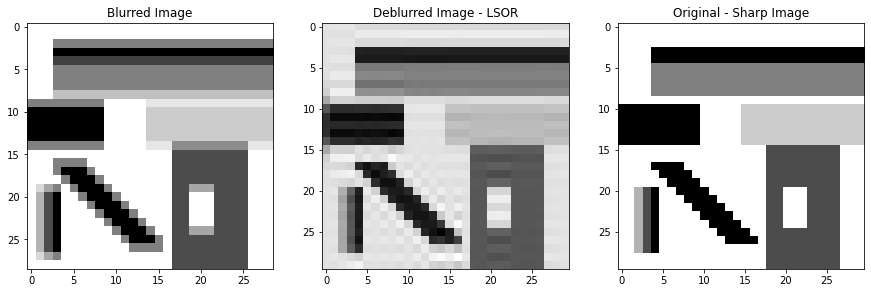

For lambda 0.00550
Loss Data Term = 0.04486
Sum of Squared Distance: deblurred vs. original = 0.02332


In [331]:
# TODO
w = 0.3  #play with this TODO

# run LSOR algorithm
img_deblurred_sor = LSOR(img_blurred, reg_lambda, w)

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_sor, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LSOR")
ax3.set_title("Original - Sharp Image")
# plt.savefig("results_" + str(k) + ".png")
plt.show()

print(f"For lambda {reg_lambda:.5f}")
print(f"Loss Data Term = {compute_loss(img_blurred, img_deblurred_sor, kernel):.5f}")
print(f"Sum of Squared Distance: deblurred vs. original = {compute_diff(img_deblurred_sor, sample_image):.5f}")



## GAUSS - SEIDEL

In [332]:
# TODO
nb_iter = 1

# run LGS algorithm
img_deblurred_gs = LGS(img_blurred, reg_lambda)

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gs, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LGS")
ax3.set_title("Original - Sharp Image")
#plt.savefig("figures/results_LSOR_"+str(k)+".png")
plt.show()

print(f"For lambda {reg_lambda:.5f}")
print(f"Loss Data Term = {compute_loss(img_blurred, img_deblurred_gs, kernel):.5f}")
print(f"Sum of Squared Distance: deblurred vs. original = {compute_diff(img_deblurred_gs, sample_image):.5f}")

ValueError: Sparse matrices are not supported by this function. Perhaps one of the scipy.sparse.linalg functions would work instead.